# DS106 Capstone Project : Topic Modelling with Sentiment Analysis

The aim of this project is to sieve out the underlying topics from unstructured text data (hotel reviews) followed by sentiment analysis of the reviews. The hotels that this project will focus on are budget hotels under the Ibis Singapore group. There are a total of 13 budget hotels under the Ibis Singapore brand. 

The topic modelling and sentiment analysis of the data will be useful for hotel managers when it comes to identifying the pain points experienced by hotel guests, which increases the efficiency of their service recovery and improve the overall quality of the guests' experience. Good service quality and experience will usually lead to an increase in the number of repeat guests and attract new guests. This translates to higher revenue for the hotels. 

The reviews for the 13 budget hotels used in this project were scraped from TripAdvisor (code can be found in repo). 

**Flow of this project**

1. Import relevant libraries and dataset
2. Text pre-processing 
3. Topic Modelling using Latent Dirichlet Allocation
4. Sentiment Analysis using TextBlob
5. Exploratory Data Analysis
6. Summary


## 1.  Import Relevant Libraries and Dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
import seaborn as sns

sns.set_style('whitegrid')

import re
import string

import gensim
import gensim.downloader as api
import nltk
from cleantext import clean
from gensim.corpora.dictionary import Dictionary
from gensim.models.keyedvectors import KeyedVectors
from gensim.summarization import keywords
from gensim.test.utils import common_texts
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pylab import rcParams
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer,
                                             TfidfVectorizer)
from wordcloud import WordCloud

#nltk.download('vader_lexicon')
import pickle
import unicodedata
import warnings

import contractions
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.gensim_models as gensimvi
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

warnings.filterwarnings('ignore')
import spacy
from spacy.lang.en import English

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = English()
from spacy.lang.en.stop_words import STOP_WORDS



Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yeosi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\yeosi\anaconda3\envs\baseclone\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [2]:
# Import dataset
df = pd.read_csv('ibis_budget_reviews.csv')
df

,Hotel_Name,Date,Title,Review,Rating
0,ibis budget Singapore Pearl,April 2022,When they say budget they mean budget,When they say budget they really mean budget. ...,2
1,ibis budget Singapore Pearl,January 2021,Poor customer service,This hotel does not live up to expectation of ...,3
2,ibis budget Singapore Pearl,February 2020,It's okay,We stayed 4 nights. We got free room promotion...,3
3,ibis budget Singapore Pearl,February 2020,Average stay,Located in an area that looks a little more ru...,3
4,ibis budget Singapore Pearl,January 2020,Good budget Hotel,Ibis pearl is good budget hotel in geylang are...,3
...,...,...,...,...,...
5324,ibis budget Singapore Selegie,December 2016,"Accesible, but tiny rooms😓",This hotel was located near Orchard road and m...,3
5325,ibis budget Singapore Selegie,September 2017,F1 weekend,Hotel is close to really good restaurants and ...,4
5326,ibis budget Singapore Selegie,November 2017,Amazing hotel in the heart of Singapore,"Beside the supper comfort, facilities and acco...",4
5327,ibis budget Singapore Selegie,October 2017,Worth it <3,Great place to stay! ^_^ Walking distance to m...,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5329 entries, 0 to 5328
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hotel_Name  5329 non-null   object
 1   Date        5329 non-null   object
 2   Title       5329 non-null   object
 3   Review      5329 non-null   object
 4   Rating      5329 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 208.3+ KB


Text(0.5, 1.0, 'Distribution of Ratings')

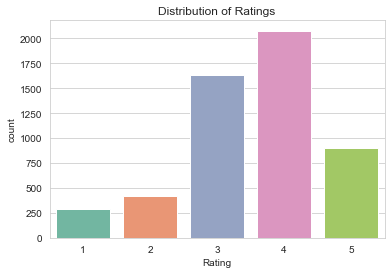

In [406]:
# Visualise the distribution of ratings given ny guests
sns.countplot(x = 'Rating', data= df, palette = 'Set2').set_title('Distribution of Ratings')

In [6]:
# Convert ratings to sentiments ( Positive, negative, neutral)
df['Ori_Rating'] = df['Rating'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

Text(0.5, 1.0, 'Distribution of Sentiments')

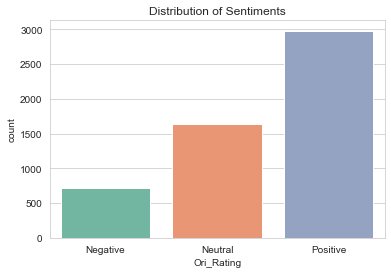

In [407]:
# Visualise the distribution of sentiments 
sns.countplot(x = 'Ori_Rating', data= df, palette = 'Set2').set_title('Distribution of Sentiments')

## 2. Text Pre-processing 

- To lower case
- Remove noise - punctuations, emoticons, accented words
- Expand contractions 
- Tokenisation
- Stopword Removal ( remove 'Not' from stopword bag)
- Stemming /lemmatization

In [8]:
# Loading list of stop words from NLTK
stop_words = set(stopwords.words('english'))

# Remove word 'not' in stopwords as Not can depict emotions
stop_words.remove('not')

In [9]:
# Create function to define and remove custom stopwords 
def remove_custom_stopwords(text):
    stopset = set(stopwords.words("english"))
    for word in ['via', 'etc','very', 'hotel', 'room', 'stay', 'square', 'would', 'also', 'singapore', 'clarke', 'quay','ibis']:
        stopset.add(word)
  
    text = ' '.join([word for word in text.split() if word not in stopset])
    return text


In [10]:
# Create a function to map Part of Speech tags to the tokens
def pos_tag_wordnet(tagged_tokens):
    tag_map = {'j': wordnet.ADJ, 'v': wordnet.VERB, 'n': wordnet.NOUN, 'r': wordnet.ADV}
    new_tagged_tokens = [(word, tag_map.get(tag[0].lower(), wordnet.NOUN))
                            for word, tag in tagged_tokens]
    return new_tagged_tokens

In [11]:
# Create a function to process and clean texts 
def text_processing(review):
    
    #tokenize
    text = nltk.word_tokenize(review)
    
    #conver to lowercase 
    text = [t.lower() for t in text]
    
    # remove symbol
    text = [re.sub(r'^\d\w\s','',t) for t in text]
    
    #remove brackets
    text = [t.replace("(","").replace(")","") for t in text]
     
    # remove punctuation
    text = [t for t in text if t.isalnum()]
    
    # remove stopwords
    text  = [t for t in text if t not in  stop_words]
    
    #remove contractions
    text = [contractions.fix(t) for t in text]
    
    #Remove numbers
    text = [re.sub('\w*\d\w*', '', t) for t in text]
    
    #Remove ascii char
    text = [unicodedata.normalize('NFKD', t).encode('ascii', 'ignore').decode('utf-8', 'ignore') for t in text]
     
    #Remove empty tokens
    text = [t for t in text if t]
        
    #POS tagging
    text = nltk.pos_tag(text)
    text = pos_tag_wordnet(text)
    
    # Lemmatization
    lemma = WordNetLemmatizer()
    text = [lemma.lemmatize(t,tag) for t,tag in text]
    
    #Join tokens
    text = ' '.join(text)
    
    return text
    

In [12]:
df['Review'] = df['Review'].apply(text_processing)
df

,Hotel_Name,Date,Title,Review,Rating,Ori_Rating
0,ibis budget Singapore Pearl,April 2022,When they say budget they mean budget,say budget really mean budget stay double room...,2,Negative
1,ibis budget Singapore Pearl,January 2021,Poor customer service,hotel not live expectation service standard ac...,3,Neutral
2,ibis budget Singapore Pearl,February 2020,It's okay,stayed night get free room promotion double ro...,3,Neutral
3,ibis budget Singapore Pearl,February 2020,Average stay,locate area look little run rest singapore fel...,3,Neutral
4,ibis budget Singapore Pearl,January 2020,Good budget Hotel,ibis pearl good budget hotel geylang area room...,3,Neutral
...,...,...,...,...,...,...
5324,ibis budget Singapore Selegie,December 2016,"Accesible, but tiny rooms😓",hotel locate near orchard road midway little i...,3,Neutral
5325,ibis budget Singapore Selegie,September 2017,F1 weekend,hotel close really good restaurant local shop ...,4,Positive
5326,ibis budget Singapore Selegie,November 2017,Amazing hotel in the heart of Singapore,beside supper comfort facility accomodations h...,4,Positive
5327,ibis budget Singapore Selegie,October 2017,Worth it <3,great place stay walk distance mustafa one rid...,5,Positive


In [13]:
#remove custome stopwords
df['Review'] = df['Review'].apply(remove_custom_stopwords)

In [14]:
df.head()

,Hotel_Name,Date,Title,Review,Rating,Ori_Rating
0,ibis budget Singapore Pearl,April 2022,When they say budget they mean budget,say budget really mean budget double basically...,2,Negative
1,ibis budget Singapore Pearl,January 2021,Poor customer service,live expectation service standard accord membe...,3,Neutral
2,ibis budget Singapore Pearl,February 2020,It's okay,stayed night get free promotion double family ...,3,Neutral
3,ibis budget Singapore Pearl,February 2020,Average stay,locate area look little run rest felt safe alt...,3,Neutral
4,ibis budget Singapore Pearl,January 2020,Good budget Hotel,pearl good budget geylang area compact amenity...,3,Neutral


## 3.  Topic Modeling - Latent Dirichlet Allocation 

Topic modelling will be done through unsupervised machine learning technique - Latent Dirichlet Allocation. It allows us to extract the underlying topics for the hotel reviews and streamline the review categorization process. From the results , the hotel manager will be able to look at the different topics that the hotel guests had provided reviews for. 

In [80]:
# Create a function to run LDA Model and return pyLDAVis plot ,perplexity and coherence score
def LDA(df):
    
    # Tokenise the reviews and convert it to a document term matrix    
    Tokens = df['Review'].apply(lambda review: nltk.word_tokenize(review))
    dictionary = corpora.Dictionary(Tokens)
    doc_term_matrix = [dictionary.doc2bow(rev) for rev in Tokens]

    # Creating the object for LDA model using gensim library
    LDA = gensim.models.ldamodel.LdaModel

    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus = doc_term_matrix, 
                                            id2word=dictionary, 
                                            num_topics= 5,                 # 5 topics makes most sense in terms of topic interpretability
                                            random_state=123, 
                                            update_every=1,
                                            chunksize = 1000,
                                            passes = 20,
                                            alpha='auto')
    
    # Compute perplexity score
    perplexity = lda_model.log_perplexity(doc_term_matrix,total_docs= len(df))
    print('Perplexity Score: ', perplexity)
        
    # Compute coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts= Tokens, dictionary=dictionary , coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)

    #Visualise the topics 
    pyLDAvis.enable_notebook()
    vis=pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary, mds = 'mmds', R=30)
    vis

    return vis,lda_model, doc_term_matrix, Tokens

In [81]:
vis, lda_model,doc_term_matrix, Tokens = LDA(df)

Perplexity Score:  -6.9181136227394555

Coherence Score:  0.41425302661005226


In [82]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.129678 -0.156828       1        1  45.832588
0     -0.017036  0.186344       2        1  25.132414
4     -0.108444 -0.274313       3        1  13.510597
3     -0.275161  0.118162       4        1   9.030965
1      0.270962  0.126635       5        1   6.493435, topic_info=        Term         Freq        Total Category  logprob  loglift
31      walk  1940.000000  1940.000000  Default  30.0000  30.0000
67       mrt  1613.000000  1613.000000  Default  29.0000  29.0000
29   station  1438.000000  1438.000000  Default  28.0000  28.0000
115      bus   939.000000   939.000000  Default  27.0000  27.0000
87      area  1409.000000  1409.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
22        ok   100.209821   597.934093   Topic5  -4.9438   0.9482
68      nice   100.778343  1361.193166   Topic5  -4.9382   0.1312
34     check    89.201459   764.392039   Topic5  -5.0602   0.5862
75     price    91.725499  1145.085293   Topic5  -5.0323   0.2099
5     budget    89.929994  1172.735840   Topic5  -5.0521   0.1663

[374 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
418       1  0.296870    accessible
418       4  0.695109    accessible
1460      4  0.982926  accomodation
797       4  0.994558     advantage
2147      5  0.982603           age
...     ...       ...           ...
176       3  0.154453       without
176       5  0.406455       without
2487      5  0.972353       working
352       1  0.997480           yet
7611      5  0.987372         zzzzz

[597 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 4, 2])

In [83]:
#Create a function to generate wordclouds for all topics for better visualisation
def wordcloud_LDA(lda_model):
    cloud =  wordcloud = WordCloud(width=1000, height=1000, random_state=1, background_color='White', 
                          colormap='Set2', collocations=False, stopwords=stop_words)

    topics = lda_model.show_topics(num_words=40, formatted = False)
    
    fig, axes = plt.subplots(1, 5, figsize=(18,18), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

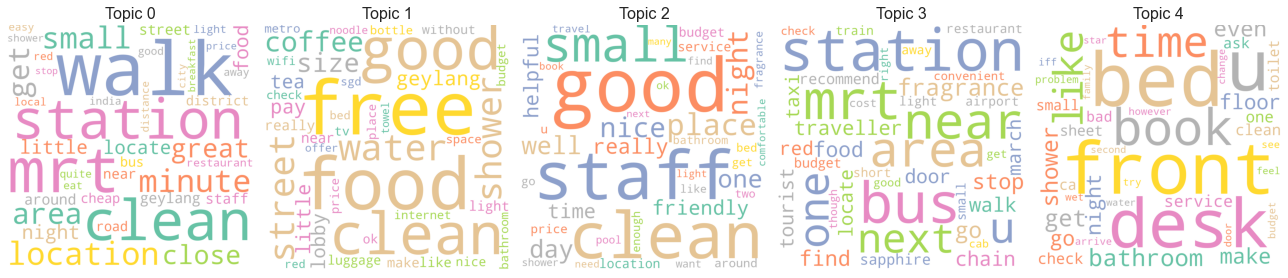

In [84]:
wordcloud_LDA(lda_model)

## Topic Allocation

`With this, topics words can be interpreted and topics can be allocated accordingly. 

**Topic Allocation**

- Topic 0 - Night Life  
- Topic 1 - Value for Money 
- Topic 2 - Service 
- Topic 3 - Location 
- Topic 4 - Room Amenities 

In [60]:
# Create a function to allocate the dominant topic to each review 
def format_topics_sent(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: x[1], reverse=True)
        
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_topic', 'Perc_Contrib', 'Topic_Keywords']
   
    contents = df['Review']
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.rename(columns={0: "Text"}, inplace=True)
    return sent_topics_df

In [87]:
topic_df = format_topics_sent(lda_model, doc_term_matrix, df)

In [88]:
topic_df

,Dominant_topic,Perc_Contrib,Topic_Keywords,Review
0,4.0,0.4447,"bed, front, u, desk, book, time, like, bathroo...",say budget really mean budget double basically...
1,2.0,0.4731,"good, staff, clean, small, place, night, nice,...",live expectation service standard accord membe...
2,0.0,0.5166,"walk, mrt, clean, station, location, minute, s...",stayed night get free promotion double family ...
3,0.0,0.4416,"walk, mrt, clean, station, location, minute, s...",locate area look little run rest felt safe alt...
4,0.0,0.6898,"walk, mrt, clean, station, location, minute, s...",pearl good budget geylang area compact amenity...
...,...,...,...,...
5324,0.0,0.7570,"walk, mrt, clean, station, location, minute, s...",locate near orchard road midway little india s...
5325,0.0,0.6384,"walk, mrt, clean, station, location, minute, s...",close really good restaurant local shop love s...
5326,2.0,0.5286,"good, staff, clean, small, place, night, nice,...",beside supper comfort facility accomodations s...
5327,0.0,0.7892,"walk, mrt, clean, station, location, minute, s...",great place walk distance mustafa one ride awa...


In [89]:
topic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5329 entries, 0 to 5328
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Dominant_topic  5329 non-null   float64
 1   Perc_Contrib    5329 non-null   float32
 2   Topic_Keywords  5329 non-null   object 
 3   Review          5329 non-null   object 
dtypes: float32(1), float64(1), object(2)
memory usage: 145.8+ KB


In [92]:
# Convert data type of dominant topic to integer 
topic_df['Dominant_topic']= topic_df['Dominant_topic'].astype('int64')

In [97]:
topic_df.head()

,Dominant_topic,Perc_Contrib,Topic_Keywords,Review
0,4,0.4447,"bed, front, u, desk, book, time, like, bathroo...",say budget really mean budget double basically...
1,2,0.4731,"good, staff, clean, small, place, night, nice,...",live expectation service standard accord membe...
2,0,0.5166,"walk, mrt, clean, station, location, minute, s...",stayed night get free promotion double family ...
3,0,0.4416,"walk, mrt, clean, station, location, minute, s...",locate area look little run rest felt safe alt...
4,0,0.6898,"walk, mrt, clean, station, location, minute, s...",pearl good budget geylang area compact amenity...


In [98]:
df.head()

,Hotel_Name,Date,Title,Review,Rating,Ori_Rating
0,ibis budget Singapore Pearl,April 2022,When they say budget they mean budget,say budget really mean budget double basically...,2,Negative
1,ibis budget Singapore Pearl,January 2021,Poor customer service,live expectation service standard accord membe...,3,Neutral
2,ibis budget Singapore Pearl,February 2020,It's okay,stayed night get free promotion double family ...,3,Neutral
3,ibis budget Singapore Pearl,February 2020,Average stay,locate area look little run rest felt safe alt...,3,Neutral
4,ibis budget Singapore Pearl,January 2020,Good budget Hotel,pearl good budget geylang area compact amenity...,3,Neutral


In [113]:
# Merge the orginal df to the topic_df for overview and furtehr analysis
final_df = df.merge(topic_df,left_index = True, right_index = True)

In [119]:
final_df = final_df.drop('Review_y', axis = 1)

In [121]:
final_df.rename(columns={'Review_x': 'Review'}, inplace=True)

In [122]:
final_df

,Hotel_Name,Date,Title,Review,Rating,Ori_Rating,Dominant_topic,Perc_Contrib,Topic_Keywords
0,ibis budget Singapore Pearl,April 2022,When they say budget they mean budget,say budget really mean budget double basically...,2,Negative,4,0.4447,"bed, front, u, desk, book, time, like, bathroo..."
1,ibis budget Singapore Pearl,January 2021,Poor customer service,live expectation service standard accord membe...,3,Neutral,2,0.4731,"good, staff, clean, small, place, night, nice,..."
2,ibis budget Singapore Pearl,February 2020,It's okay,stayed night get free promotion double family ...,3,Neutral,0,0.5166,"walk, mrt, clean, station, location, minute, s..."
3,ibis budget Singapore Pearl,February 2020,Average stay,locate area look little run rest felt safe alt...,3,Neutral,0,0.4416,"walk, mrt, clean, station, location, minute, s..."
4,ibis budget Singapore Pearl,January 2020,Good budget Hotel,pearl good budget geylang area compact amenity...,3,Neutral,0,0.6898,"walk, mrt, clean, station, location, minute, s..."
...,...,...,...,...,...,...,...,...,...
5324,ibis budget Singapore Selegie,December 2016,"Accesible, but tiny rooms😓",locate near orchard road midway little india s...,3,Neutral,0,0.7570,"walk, mrt, clean, station, location, minute, s..."
5325,ibis budget Singapore Selegie,September 2017,F1 weekend,close really good restaurant local shop love s...,4,Positive,0,0.6384,"walk, mrt, clean, station, location, minute, s..."
5326,ibis budget Singapore Selegie,November 2017,Amazing hotel in the heart of Singapore,beside supper comfort facility accomodations s...,4,Positive,2,0.5286,"good, staff, clean, small, place, night, nice,..."
5327,ibis budget Singapore Selegie,October 2017,Worth it <3,great place walk distance mustafa one ride awa...,5,Positive,0,0.7892,"walk, mrt, clean, station, location, minute, s..."


## 4. Sentiment Analysis with TextBlob 

After the underlying topics were sieved out and allocated to each review successfully, sentiment analysis will be performed using textBlobs for the reviews. This allows us to get a sensing of how the hotel guests feel about each topic in the EDA section. 

In [124]:
# Create a function to analysis sentiments of reviews using TextBlob
def sentiment_analysis(df):
 #Create a function to get the polarity
    def getPolarity(text):
        return TextBlob(text).sentiment.polarity
  
 #Create two new columns ‘Polarity’)
    df['TextBlob_Polarity'] = df['Review'].apply(getPolarity)
    
    def getAnalysis(score):
        if score <= -0.05:
            return 'Negative'
        elif score >= 0.15:
            return 'Positive'
        else:
            return 'Neutral'
     
    df['Pol_Rating'] = df['TextBlob_Polarity'].apply(getAnalysis )

    return  df

In [125]:
sentiment_analysis(final_df)

,Hotel_Name,Date,Title,Review,Rating,Ori_Rating,Dominant_topic,Perc_Contrib,Topic_Keywords,TextBlob_Polarity,Pol_Rating
0,ibis budget Singapore Pearl,April 2022,When they say budget they mean budget,say budget really mean budget double basically...,2,Negative,4,0.4447,"bed, front, u, desk, book, time, like, bathroo...",0.069097,Neutral
1,ibis budget Singapore Pearl,January 2021,Poor customer service,live expectation service standard accord membe...,3,Neutral,2,0.4731,"good, staff, clean, small, place, night, nice,...",-0.035606,Neutral
2,ibis budget Singapore Pearl,February 2020,It's okay,stayed night get free promotion double family ...,3,Neutral,0,0.5166,"walk, mrt, clean, station, location, minute, s...",0.201111,Positive
3,ibis budget Singapore Pearl,February 2020,Average stay,locate area look little run rest felt safe alt...,3,Neutral,0,0.4416,"walk, mrt, clean, station, location, minute, s...",0.221528,Positive
4,ibis budget Singapore Pearl,January 2020,Good budget Hotel,pearl good budget geylang area compact amenity...,3,Neutral,0,0.6898,"walk, mrt, clean, station, location, minute, s...",0.400000,Positive
...,...,...,...,...,...,...,...,...,...,...,...
5324,ibis budget Singapore Selegie,December 2016,"Accesible, but tiny rooms😓",locate near orchard road midway little india s...,3,Neutral,0,0.7570,"walk, mrt, clean, station, location, minute, s...",-0.047917,Neutral
5325,ibis budget Singapore Selegie,September 2017,F1 weekend,close really good restaurant local shop love s...,4,Positive,0,0.6384,"walk, mrt, clean, station, location, minute, s...",0.336111,Positive
5326,ibis budget Singapore Selegie,November 2017,Amazing hotel in the heart of Singapore,beside supper comfort facility accomodations s...,4,Positive,2,0.5286,"good, staff, clean, small, place, night, nice,...",0.409722,Positive
5327,ibis budget Singapore Selegie,October 2017,Worth it <3,great place walk distance mustafa one ride awa...,5,Positive,0,0.7892,"walk, mrt, clean, station, location, minute, s...",0.277083,Positive


### Allocate topics to the Dominant topic groups

In [166]:
topic_mapping = {0: 'Night Life', 1: 'Value for Money', 2: 'Service', 3: 'Location', 4: 'Room Amenities'}

final_df['Topic'] = final_df['Dominant_topic'].map(topic_mapping)

### Add Review Length as a column

In [294]:
final_df['Review_Len'] = final_df['Review'].apply(lambda x: len(str(x).split(" ")))
final_df.head()

,Hotel_Name,Date,Title,Review,Rating,Ori_Rating,Dominant_topic,Perc_Contrib,Topic_Keywords,TextBlob_Polarity,Pol_Rating,Topic,Review_Len
0,ibis budget Singapore Pearl,April 2022,When they say budget they mean budget,say budget really mean budget double basically...,2,Negative,4,0.4447,"bed, front, u, desk, book, time, like, bathroo...",0.069097,Neutral,Room Amenities,36
1,ibis budget Singapore Pearl,January 2021,Poor customer service,live expectation service standard accord membe...,3,Neutral,2,0.4731,"good, staff, clean, small, place, night, nice,...",-0.035606,Neutral,Service,25
2,ibis budget Singapore Pearl,February 2020,It's okay,stayed night get free promotion double family ...,3,Neutral,0,0.5166,"walk, mrt, clean, station, location, minute, s...",0.201111,Positive,Night Life,45
3,ibis budget Singapore Pearl,February 2020,Average stay,locate area look little run rest felt safe alt...,3,Neutral,0,0.4416,"walk, mrt, clean, station, location, minute, s...",0.221528,Positive,Night Life,32
4,ibis budget Singapore Pearl,January 2020,Good budget Hotel,pearl good budget geylang area compact amenity...,3,Neutral,0,0.6898,"walk, mrt, clean, station, location, minute, s...",0.400000,Positive,Night Life,31


### Add Year as a column

In [378]:
final_df['Date'].str.split(expand = True)

,0,1
0,April,2022
1,January,2021
2,February,2020
3,February,2020
4,January,2020
...,...,...
5324,December,2016
5325,September,2017
5326,November,2017
5327,October,2017


In [390]:
final_df = final_df.join(year)

In [391]:
final_df.rename(columns = {0: 'Month', 1:'Year'}, inplace = True)

In [393]:
final_df.head()

,Hotel_Name,Date,Title,Review,Rating,Ori_Rating,Dominant_topic,Perc_Contrib,Topic_Keywords,TextBlob_Polarity,Pol_Rating,Topic,Review_Len,Month,Year
0,ibis budget Singapore Pearl,April 2022,When they say budget they mean budget,say budget really mean budget double basically...,2,Negative,4,0.4447,"bed, front, u, desk, book, time, like, bathroo...",0.069097,Neutral,Room Amenities,36,April,2022
1,ibis budget Singapore Pearl,January 2021,Poor customer service,live expectation service standard accord membe...,3,Neutral,2,0.4731,"good, staff, clean, small, place, night, nice,...",-0.035606,Neutral,Service,25,January,2021
2,ibis budget Singapore Pearl,February 2020,It's okay,stayed night get free promotion double family ...,3,Neutral,0,0.5166,"walk, mrt, clean, station, location, minute, s...",0.201111,Positive,Night Life,45,February,2020
3,ibis budget Singapore Pearl,February 2020,Average stay,locate area look little run rest felt safe alt...,3,Neutral,0,0.4416,"walk, mrt, clean, station, location, minute, s...",0.221528,Positive,Night Life,32,February,2020
4,ibis budget Singapore Pearl,January 2020,Good budget Hotel,pearl good budget geylang area compact amenity...,3,Neutral,0,0.6898,"walk, mrt, clean, station, location, minute, s...",0.400000,Positive,Night Life,31,January,2020


## 5. Exploratory Data Analysis 

The EDA section allows visualisation of the results of topic modelling and sentiment analysis. These two work hand in hand to provide useful and essential insights into the guests' experience and the specific aspects of the hotel that they are reviewing about. Hotel managers can then pinpoint the specific aspect to improve on and also know the aspects which hotel guests are positive about. 

### (a) General EDA for the reviews, sentiments and topics

**Comparison between sentiments generated by textblob and actual sentiments of hotel guests**

In [318]:
df2 = final_df[['Pol_Rating', 'Ori_Rating']]

Text(0.5, 1.0, 'Comparison between Ratings and Polarity Ratings')

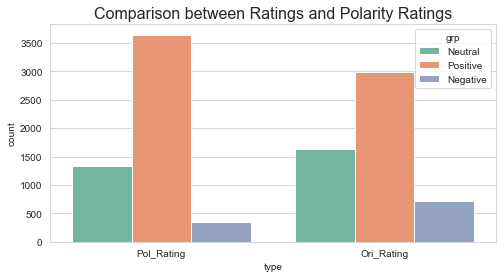

In [319]:
df2 = df2.melt(var_name='type', value_name='grp')
plt.figure(figsize = (8, 4))
sns.countplot(hue='grp', x='type', data=df2, palette = 'Set2').set_title('Comparison between Ratings and Polarity Ratings', fontsize = 16)

Sentiments generated by TextBlob are similar to the sentiments from the original ratings given by hotel guests.


**Distribution of review percentage contribution and sentiment polarity**

Text(0.5, 1.0, 'Sentiments Polarity Distribution')

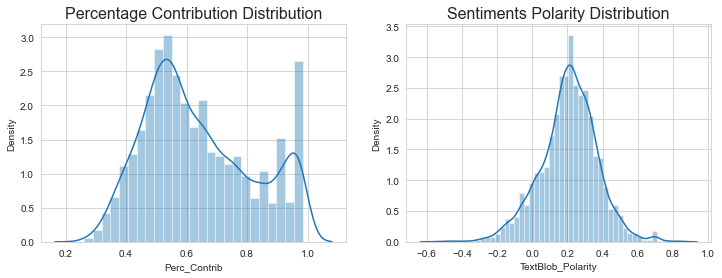

In [316]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
sns.distplot(final_df['Perc_Contrib'] ,ax = axes[0]).set_title('Percentage Contribution Distribution', fontsize = 16)
sns.distplot(final_df['TextBlob_Polarity'] ,ax = axes[1]).set_title('Sentiments Polarity Distribution', fontsize = 16)

From the histograms, most of the reviews provided substantial contribution (> 50%) to the topics, which is a sign of good topic modelling. The sentiments generated by Textblob are mostly on the positive side. 

**Find out the most common words used in Positive and Negative sentiment groups** 

In [251]:
# create individual df for processed reviews that are positive and negative respectively
# This for finding the count of the most common words
positive = final_df.loc[final_df['Pol_Rating']== 'Positive', 'Review']
negative = final_df.loc[final_df['Pol_Rating']== 'Negative', 'Review']

In [257]:
#Find the top 10 common words in positive review
fdistp = nltk.FreqDist(" ".join(positive).split()).most_common(10)
pos_c_words = pd.DataFrame(fdistp,columns = ['words', 'count'])

#Find the top 10 common words in negative review
fdistn = nltk.FreqDist(" ".join(negative).split()).most_common(10)
neg_c_words = pd.DataFrame(fdistn,columns = ['words', 'count'])

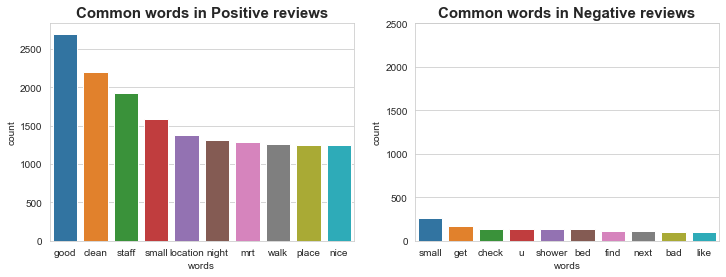

In [274]:
#plot bar chart for comparison
fig, axes = plt.subplots(1,2,figsize=(12,4))
sns.barplot(x = pos_c_words['words'], y=pos_c_words['count'],ax = axes[0]).set_title('Common words in Positive reviews', fontsize = 15, weight = 'bold')
sns.barplot(x = neg_c_words['words'], y=neg_c_words['count'],ax = axes[1]).set_title('Common words in Negative reviews', fontsize = 15, weight = 'bold')
plt.ylim(0,2500)

The common positive words seem to focus on the hotel location and service, while the common negative words focus on the room amenities and hygiene issues. 

**Review count across hotel branches**

Text(0.5, 1.0, 'No. of Reviews across Hotel Branches')

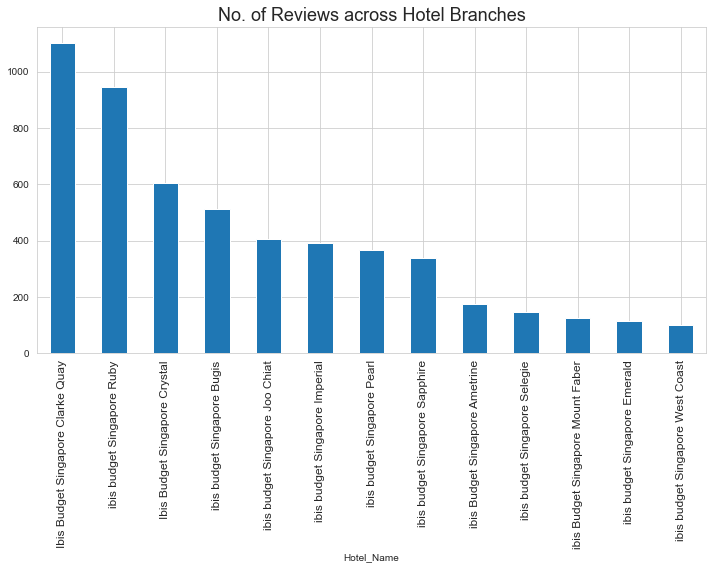

In [315]:
plt.figure(figsize = (12, 6))
final_df.groupby('Hotel_Name')['Review'].count().sort_values(ascending = False).plot(kind = 'bar')
plt.xticks(rotation=90, fontsize = 12)
plt.title('No. of Reviews across Hotel Branches', fontsize = 18)

The top 3 hotel branches are Clarke Quay, Ruby and Crystal. It would be good to look into the main sentiments and topics of their online reviews later on. 

**Sentiment Polarity across hotel branches**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'ibis budget Singapore Pearl'),
  Text(1, 0, 'ibis Budget Singapore Mount Faber'),
  Text(2, 0, 'ibis budget Singapore Emerald'),
  Text(3, 0, 'ibis budget Singapore West Coast'),
  Text(4, 0, 'ibis Budget Singapore Ametrine'),
  Text(5, 0, 'ibis budget Singapore Imperial'),
  Text(6, 0, 'ibis budget Singapore Joo Chiat'),
  Text(7, 0, 'ibis budget Singapore Bugis'),
  Text(8, 0, 'Ibis Budget Singapore Clarke Quay'),
  Text(9, 0, 'Ibis Budget Singapore Crystal'),
  Text(10, 0, 'ibis budget Singapore Ruby'),
  Text(11, 0, 'ibis budget Singapore Sapphire'),
  Text(12, 0, 'ibis budget Singapore Selegie')])

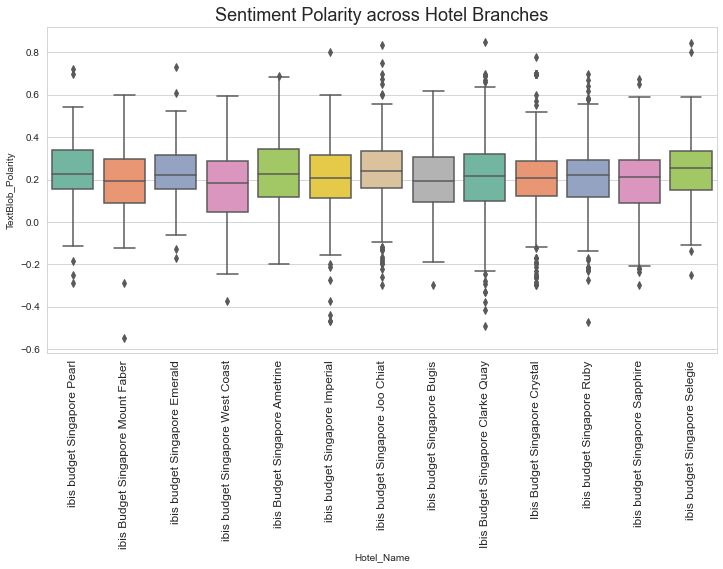

In [313]:
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'Hotel_Name', y = 'TextBlob_Polarity', data = final_df, palette = 'Set2').set_title('Sentiment Polarity across Hotel Branches', fontsize = 18)
plt.xticks(rotation=90, fontsize = 12)

The average sentiment polarity seems to be around 0.25 , which means review sentiments are slightly positive. Some branches like West Coast, Mount Faber and Bugis have lower mean polarity score compared to the others.

**Review Length by Sentiments**

Text(0.5, 1.0, 'Length of Review across Topics')

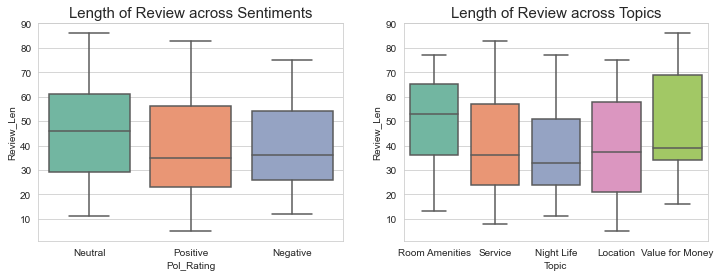

In [310]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
sns.boxplot(x = 'Pol_Rating', y = 'Review_Len', data = final_df, palette = 'Set2' ,ax = axes[0]).set_title('Length of Review across Sentiments', fontsize = 15)
sns.boxplot(x = 'Topic', y = 'Review_Len', data = final_df, palette = 'Set2',ax = axes[1]).set_title('Length of Review across Topics', fontsize = 15)

It seems that hotel guests tend to leave a significantly longer review for room amenities. Since guests actually provided longer reviews for room amenities (regardless of sentiments), the topic on room amenities could be an important one that the hotel management might want to look into. There could be pain points experience by guests for room amenities. Neutral sentiments also tend to have longer review length.

**Visualise the distribution of sentiments across the 5 topics**

Text(0.5, 1.0, 'Sentiments across Topics')

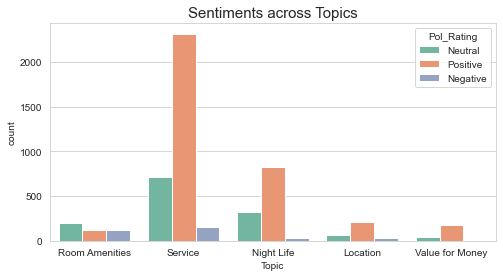

In [309]:
plt.figure(figsize = (8, 4))
sns.countplot( x = 'Topic', data = final_df, hue = 'Pol_Rating', palette = 'Set2' ).set_title('Sentiments across Topics', fontsize = 15)

Ibis budget hotels seem to be doing great for their service as this aspect has the highest number of positive reviews. Their staff and front desk service might have been well-trained and hotel guests provided compliments regarding the good service. However, the room amenities at ibis budget hotels seem to be lacking as the aspect received the lowest number of positive reviews and relatively higher number of negative reviews compared to other aspects.
This explains the reason why longer reviews were left by hotel guests regarding room amenities (from the previous plot). There could be some serious issues concerning room amenities. 

**How do the review sentiments and topics change across the years?** 

Text(0.5, 1.0, 'Topics across Year 2009 - 2022')

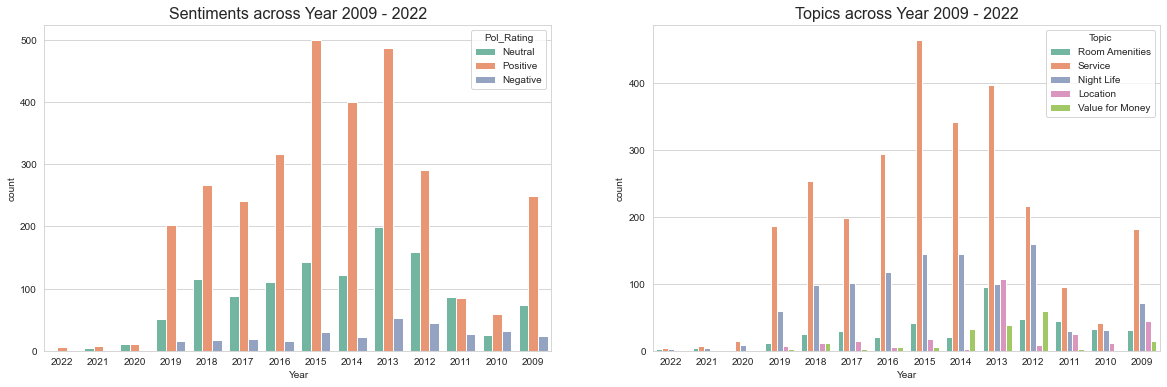

In [405]:
fig, axes = plt.subplots(1,2,figsize=(20,6))
sns.countplot( x = 'Year', data = final_df, hue = 'Pol_Rating', palette = 'Set2' ,ax = axes[0]).set_title('Sentiments across Year 2009 - 2022', fontsize = 16)
sns.countplot( x = 'Year', data = final_df, hue = 'Topic', palette = 'Set2' ,ax = axes[1]).set_title('Topics across Year 2009 - 2022', fontsize = 16)

Reviews from 2020 to 2022 are significantly lesser due to the COVID-19 situation, when the tourism industry was severely affected. However, it can also be observed that positive reviews seem to decrease from 2015 to 2019. In fact, there was a overall significant drop in the number of reviews. This was not a positive trend and it could be due to the drop in hotel guests and occupancy across the hotel branches, which led to lower number of hotel reviews. The hotel management will need to consider ways to improve their overall appeal and increase hotel occupancy during this essential period when Singapore tourism industry starts to reopen. 

Over the years, reviews are also concentrated on service and night life. Some hotel branches are located near Nightlife spots, which might draw mixed sentiments from hotel guests. As there were a significant number of reviews on Service, it would be good to look at the sentiments for this topic. 

### (b) EDA for sentiments and topics across 13 hotel branches 

**Comparison of sentiments across 13 hotel branches** 

Text(0.5, 1.0, 'Sentiments across Hotel Branches')

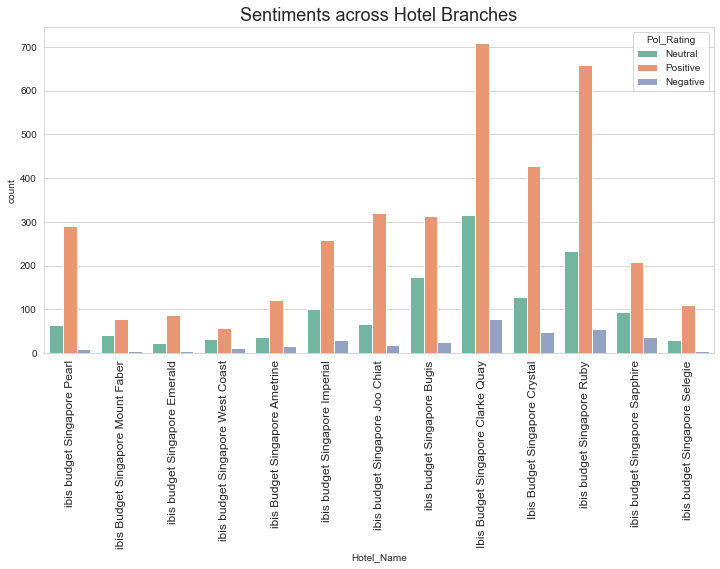

In [321]:
plt.figure(figsize = (12, 6))
sns.countplot( x = 'Hotel_Name', data = final_df, hue = 'Pol_Rating', palette = 'Set2')
plt.xticks(rotation=90, fontsize = 12)
plt.title('Sentiments across Hotel Branches', fontsize = 18)

It is a good to see that reviews are still mainly positive for all hotel branches. Across the 13 hotel branches, the top three branches with high number of positive reviews are Clarke Quay, Crystal and Ruby. These three hotels are also the top hotels for number of reviews. It seems like these three branches might also have a higher number of hotel guests compared to the rest due to the acessibility of the location, therefore leading to a higher number of reviews. Logically, due to the higher number of hotel guests, these hotel branches also have a relatively higher numbe of neutral and negative reviews. 
Hotels branches such as Selegie, Mount Faber and Emerald have lower proportion of negative reviews. 

**Comparison of topics across 13 hotel branches**

Text(0.5, 1.0, 'Topics across Hotel Branches')

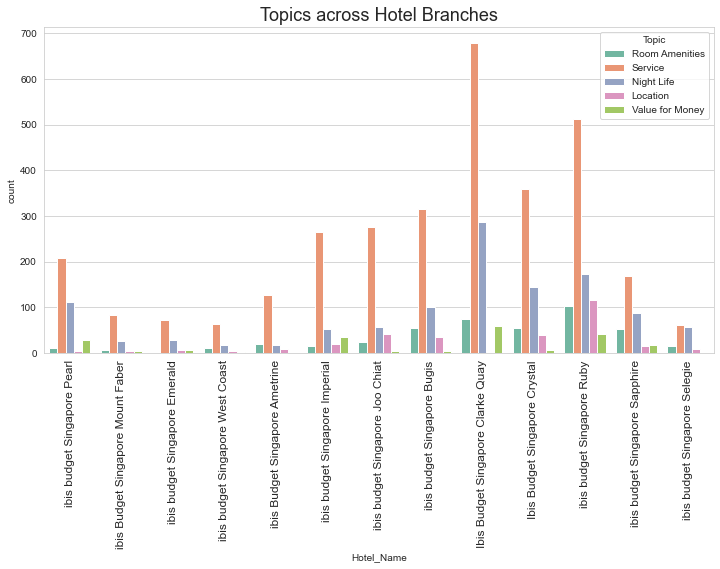

In [320]:
plt.figure(figsize = (12, 6))
sns.countplot( x = 'Hotel_Name', data = final_df, hue = 'Topic', palette = 'Set2')
plt.xticks(rotation=90, fontsize = 12)
plt.title('Topics across Hotel Branches', fontsize = 18)

Across all branches, the most common topics for reviews are Service and Night Life. Hotel branch Ruby seems to have more reviews on its location and room amenities while hotel branch Clarke Quay has the highest number of reviews for Value for Money. 

**Compare the sentiments across hotel branches for each topic**

In [223]:
# Create data subsets for each topic 
room_amen = final_df.loc[final_df['Topic']== 'Room Amenities', (['Hotel_Name', 'Pol_Rating'])]
service = final_df.loc[final_df['Topic']== 'Service', (['Hotel_Name', 'Pol_Rating'])]
night_life = final_df.loc[final_df['Topic']== 'Night Life', (['Hotel_Name', 'Pol_Rating'])]
location = final_df.loc[final_df['Topic']== 'Location', (['Hotel_Name', 'Pol_Rating'])]
value = final_df.loc[final_df['Topic']== 'Value for Money', (['Hotel_Name', 'Pol_Rating'])]

In [238]:
# Create a function to plot the countplots for each topic
def topic_sentiments(df, title):
    plt.figure(figsize = (12, 6))
    sns.countplot( x = 'Hotel_Name', data = df, hue = 'Pol_Rating', palette = 'Set2')
    plt.xticks(rotation=90, fontsize = 12)
    plt.title(title, fontsize = 18)
    plt.legend(loc = 2)

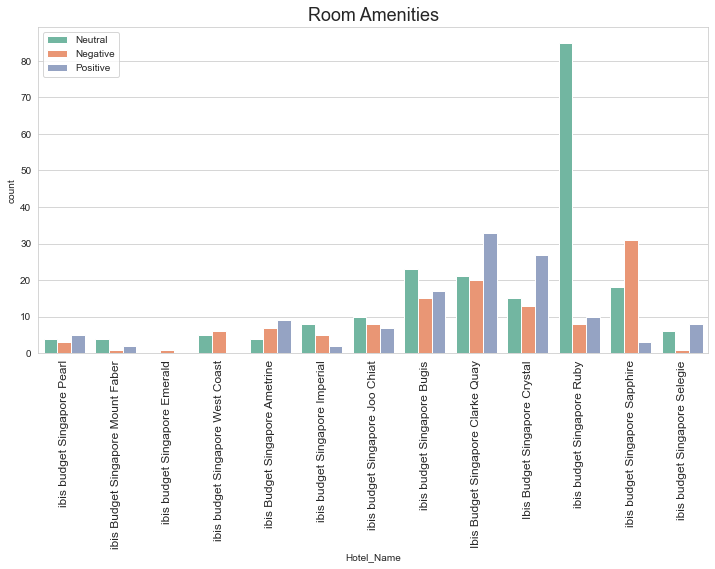

In [239]:
topic_sentiments(room_amen, 'Room Amenities')

Overall, the room amenities did not fare well. There is a higher proprtion of neutral and negative reviews, which shows that this is probably an aspect that the hotel management need to focus on. 

Hotel branch Ruby has a significant number of neutral reviews. It is essential that the hotel management look into these reviews to identify areas of
room amenities to improve on. Neutral reviews cannot be neglected as they often contain important details on the areas that can be further improved on. 

Hotel branch Sapphire would be one worthy of attention. It has the highest proportion of negative hotel reviews. This is not a good sign and indicates that there can be a lot more to work on on this aspect. Other hotel branches such as Bugis, Clarke Quay and Crystal also have high number of negative reviews. 



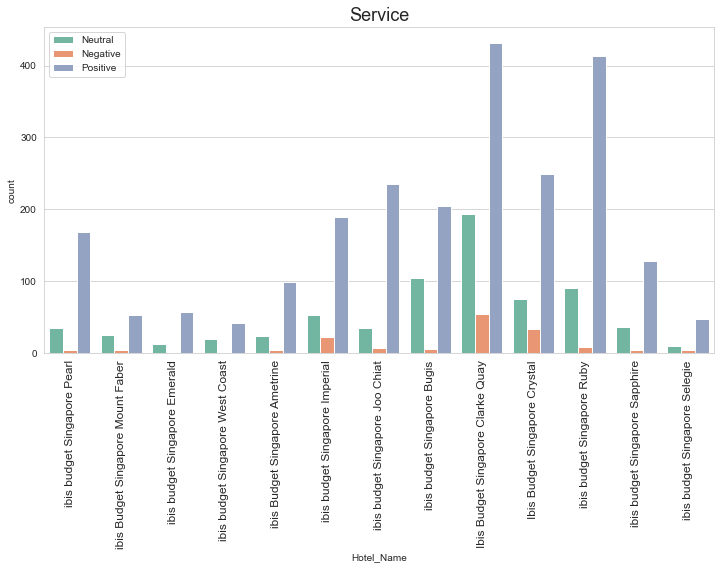

In [240]:
topic_sentiments(service, 'Service')

Overall, the service across all hotel branches seems to be positive. However, some branches like Clarke Quay, Crystal, and Imperial have relatively higher number of neutral and negative reviews. The hotel management might want to improve the service of these branches. They might want to review the service workflow of the branches or even send their service staff for a refresher course or additional training courses. 

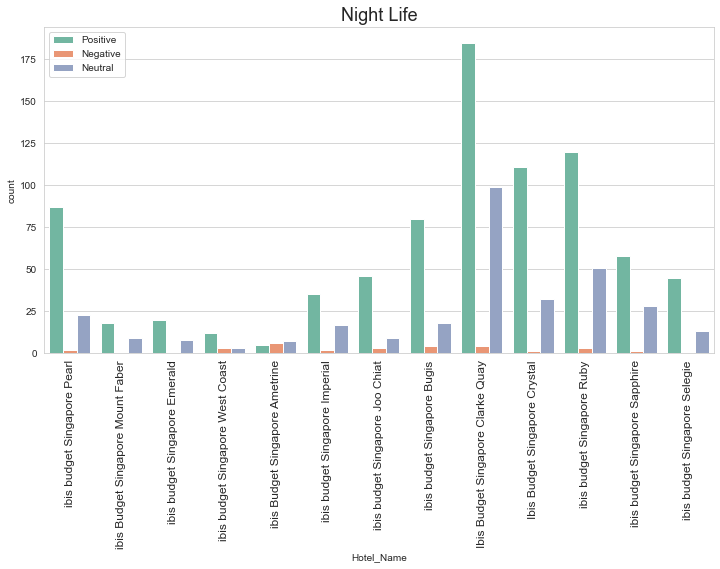

In [241]:
topic_sentiments(night_life, 'Night Life')

Reviews on Night Life seems to be mostly positive and neutral. As some hotel locations might be near Night Life spots , it may not be suitable for all hotel guests, especially families who are travelling wth young kids and elderly. Therefore, the mixed sentiments could have led to a high number of neutral reviews. However, some hotel branches such as Ametrine have higher proportion of negative reviews, which the hotel management might want to look into. 

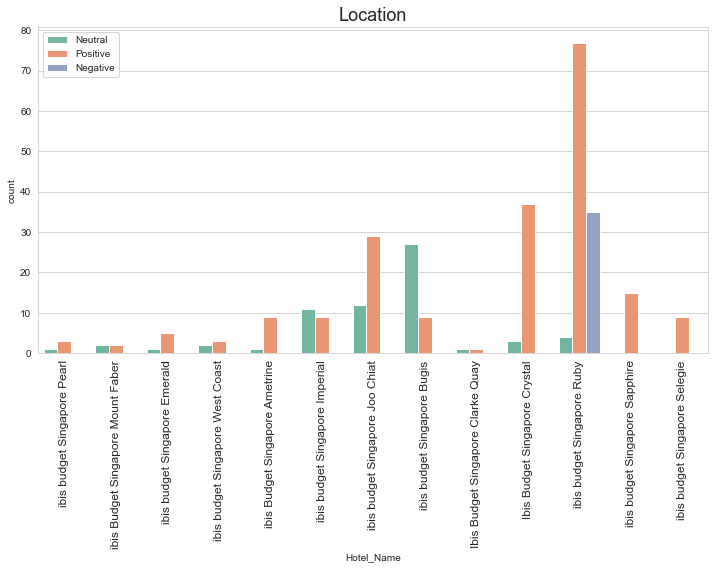

In [242]:
topic_sentiments(location, 'Location')

The location across hotel branches mostly garnered positive and neutral reviews. However, hotel branch Ruby has a high number of negative reviews. This could be due to its location which is near to the red light district in Geylang. 

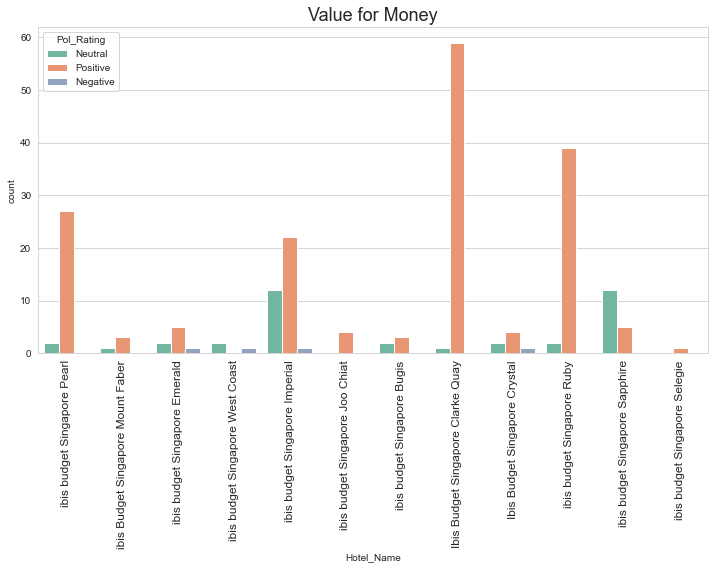

In [233]:
topic_sentiments(value, 'Value for Money')

Reviews sentiments for Value for Money are mostly positive and neutral. This could be due to the fact that ibis budget hotels are budget-friendly and mainly cater to travellers who require an overnight accomodation with basic amenities. For hotel branches in accessible locations such as Clarke Quay and Ruby, it can be an added bonus to what ibis budget hotels offer. This explains the high number of positive reviews for this aspect. 

# 6. Summary

Topic modelling and sentiment analysis helps ibis budget Singapore to uncover the underlying topics and sentiments from online reviews. This can be helpful for the hotel management to identify areas of improvement and areas that they have done well. 

**Overall, ibis budget Singapore has done well in terms of :**
1. Location
2. Value for Money
3. Service
4. Night Life

**Areas to improve on:**
1. Room Amenities 

**There are also a few hotel branches which requires attention for specific areas:**

1. Room Amenities - Ruby, Sapphire, Bugis , Clarke Quay, Crystal 
2. Service - Clarke Quay, Crystal, Imperial 
3. Night Life - Ametrine
4. Location - Ruby 

